# Building an E-Commerce Clothing Classifier Model

**Project Description**
- Transform the retail industry with cutting-edge AI: develop an innovative clothing classification system to create a smarter, more efficient shopping experience.
- Leveraging machine learning, you’ll make it easier to find the perfect outfit among a variety of choices, opening up new possibilities in the rapidly evolving digital fashion world.

**Project Instructions**
- Automate product tagging for the e-commerce store using CNNs.
- Once trained (keeping the epochs to 1 or 2 to keep the run time down), store your predictions on the test set in a list named predictions.
- Calculate the accuracy, and per-class precision and recall for your classifier based on the predictions obtained. Store your metrics in variables named accuracy, precision, and recall. Use lists of the appropriate length for the precision and recall.

![clothing_classification](images/clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

## 1. Prepare environment

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from environment import prepare_environment

from pprint import pprint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import DataLoader
from torchmetrics import Precision, Recall, Accuracy
from torchvision import datasets

In [2]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

# returns you the name of the device
GPU_DEVICE = torch.cuda.current_device()
print('Device:', torch.cuda.get_device_name(GPU_DEVICE))  

# Reviewing allocated memmory, it is 0 if there is nothing allocated
print(f"""
CUDA memory device: {torch.cuda.memory_allocated(GPU_DEVICE)}
CUDA cache  device: {torch.cuda.memory_reserved(GPU_DEVICE)}
""")

2.4.1+cu124
Cuda is available? True
Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU

CUDA memory device: 0
CUDA cache  device: 0



In [3]:
# Global variables
SEED = 42

GPU_DEVICE = torch.cuda.current_device()

MODEL_IMAGE_CLASSIFIER = "artifacts/clothing-classifier.pth"

In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)
torch.set_default_dtype(torch.float32)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

## 2. Read data

In [5]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, 
                                   transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, 
                                  transform=transforms.ToTensor())

In [6]:
# Reviewing the dataset
print(f'''
Samples in train data: 
{train_data}

Samples in test data:
{test_data}

Type: {type(train_data)}
''')


Samples in train data: 
Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Samples in test data:
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

Type: <class 'torchvision.datasets.mnist.FashionMNIST'>



In [7]:
print('Data Structure:')
print(train_data[0])

Data Structure:
(tensor([[[0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
          0.0000000000, 0.0000000000, 0.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.000000000

In [8]:
print('Categories:')
print(train_data.class_to_idx)

clothes_categories = {v: k for k, v in train_data.class_to_idx.items()}
pprint(clothes_categories)

Categories:
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}


torch.Size([1, 28, 28])
Image reshaped torch.Size([28, 28, 1])


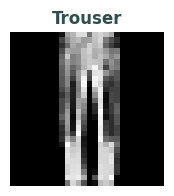

In [9]:
# Reviewing image kind
i = np.random.randint(0, 60000)
image, label = train_data[i]
print(image.shape)

# image = image[0]
# print("Data point:", image.shape)
# image = image.squeeze()
image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)
fig = plt.figure(figsize=(2, 2))
plt.title(clothes_categories[label])
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.show()

## 3. Get dataloader

In [10]:
# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(train_data, batch_size=50, shuffle=True)
dataloader_test = DataLoader(test_data, batch_size=50, shuffle=True)

## 4. Build model

In [11]:
# Build the classifier model
num_classes = len(clothes_categories.keys())
class ClotheClassifierModel(nn.Module):
    """Image Classifier model for clothing categorizing.
    """
    def __init__(self, 
                 num_classes:int=num_classes, 
                 seed:int=SEED) -> None:
        super().__init__()
        torch.manual_seed(SEED)
        
        self.feature_extractor = nn.Sequential(             # Img input: 1X28X28 (channel,w,h)
            nn.Conv2d(1, 16, 
                      kernel_size=3, stride=1, padding=1),  # In ch=1, out ch=16 → 16X28X28
            nn.ELU(),                                       # No Changes → 16X28X28
            nn.MaxPool2d(kernel_size=2),                    # Divide image size by 2 → 16X14X14
            nn.Flatten(),                                   # Flatten image → 16X14X14
        )
        self.classifier = nn.Linear(16*14*14, num_classes)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [12]:
# Build the model
model = ClotheClassifierModel()
print(f"Are we using GPU? {next(model.parameters()).is_cuda}\n")
print(model)

# Set the criterion and teh optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # weight_decay=1e-4

Are we using GPU? False

ClotheClassifierModel(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=3136, out_features=10, bias=True)
)


## 5. Train model

In [13]:
# Train the model
losses = []
epochs = 5

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for X, y in dataloader_train:    # Get feature and target from the data loader
        optimizer.zero_grad()        # zero the parameter gradients
        y_out = model(X)             # Run a forward pass
        loss = criterion(y_out, y)   # Compute loss
        loss.backward()              # Backward pass
        optimizer.step()             # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)        # Record the loss per epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 1, Loss: 0.487837
Epoch 2, Loss: 0.356945
Epoch 3, Loss: 0.320481
Epoch 4, Loss: 0.295947
Epoch 5, Loss: 0.278657


In [14]:
print(f"""
y_out: {y_out[0]}
y    : {y[0]}
""")


y_out: tensor([ -1.1081143618,  -4.1637082100,   4.2062954903,  -0.1901845038,
          5.5388460159, -15.6727142334,   7.0854635239, -18.9746856689,
         -2.1263461113, -14.4011688232], grad_fn=<SelectBackward0>)
y    : 6



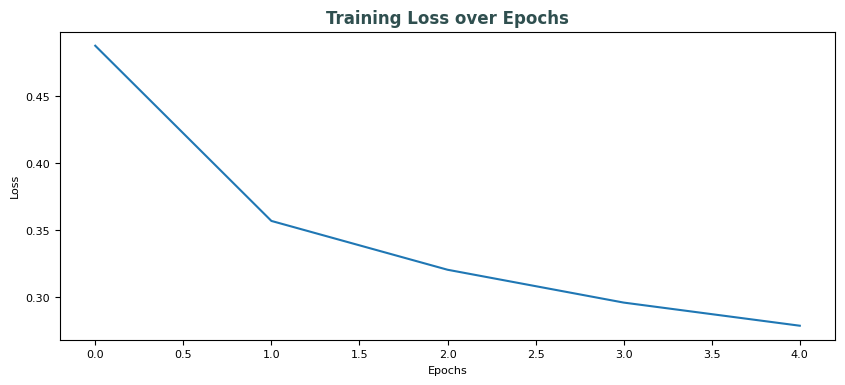

In [15]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Save model

In [16]:
# Saving the model
torch.save(model, MODEL_IMAGE_CLASSIFIER)

In [17]:
# Load the model
model = torch.load(MODEL_IMAGE_CLASSIFIER, weights_only=False)

## 7. Evaluate model

In [18]:
# Set the evaluation metrics
# Globally
metric_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
# Per class
metric_precision = Precision(task="multiclass", num_classes=num_classes, average=None)                               
metric_recall = Recall(task="multiclass", num_classes=num_classes, average=None)

# Evaluation loop
targets = torch.empty(0)
predictions = torch.empty(0)
model.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        targets = torch.cat([targets, labels])
        predictions = torch.cat([predictions, preds])
        metric_accuracy(preds, labels)
        metric_precision(preds, labels)
        metric_recall(preds, labels)
accuracy = metric_accuracy.compute()
precision = metric_precision.compute()
recall = metric_recall.compute()

## 8. Review results

In [19]:
# Print computed metrics
precision_per_class = {k: precision[v].item() for k, v in test_data.class_to_idx.items()}
recall_per_class = {k: recall[v].item() for k, v in test_data.class_to_idx.items()}

print('Accuracy:', accuracy.item())
print(f"Precision:")
pprint(precision_per_class)
print(f"Recall:")
pprint(recall_per_class)

Accuracy: 0.8895000219345093
Precision:
{'Ankle boot': 0.9752832055091858,
 'Bag': 0.9866392612457275,
 'Coat': 0.8147029280662537,
 'Dress': 0.8937875628471375,
 'Pullover': 0.8186274766921997,
 'Sandal': 0.9846153855323792,
 'Shirt': 0.6875621676445007,
 'Sneaker': 0.9252601861953735,
 'T-shirt/top': 0.8333333134651184,
 'Trouser': 0.9857434034347534}
Recall:
{'Ankle boot': 0.9470000267028809,
 'Bag': 0.9599999785423279,
 'Coat': 0.8090000152587891,
 'Dress': 0.8920000195503235,
 'Pullover': 0.8349999785423279,
 'Sandal': 0.9599999785423279,
 'Shirt': 0.6909999847412109,
 'Sneaker': 0.9779999852180481,
 'T-shirt/top': 0.8550000190734863,
 'Trouser': 0.9679999947547913}


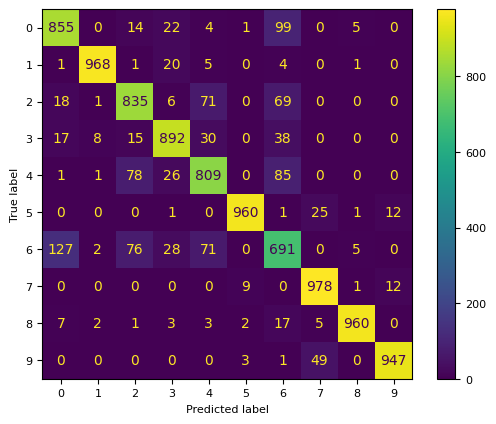

In [20]:
cm = confusion_matrix(targets.numpy(), predictions.numpy())
_ = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [21]:
pd.DataFrame({
    'Original Label': targets.numpy(),
    'Predicted Label': predictions.numpy(),
    'Accerted': ['True' 
                 if targets.numpy()[i] == predictions.numpy()[i]
                 else ''
                 for i in range(len(targets))] 
})

,Original Label,Predicted Label,Accerted
0,1.0,1.0,True
1,0.0,6.0,
2,2.0,2.0,True
3,7.0,7.0,True
4,9.0,9.0,True
...,...,...,...
9995,9.0,9.0,True
9996,5.0,5.0,True
9997,1.0,3.0,
9998,8.0,8.0,True


## 9. Close environment

In [22]:
# Reviewing allocated memmory, it is 0 if there is nothing allocated
cuda_memory = torch.cuda.memory_allocated(GPU_DEVICE)
cuda_cache = torch.cuda.memory_reserved(GPU_DEVICE)
print(f"""
CUDA memory device: {cuda_memory}
CUDA cache  device: {cuda_cache}
""")

# Free allocated memory
torch.cuda.empty_cache() 


CUDA memory device: 0
CUDA cache  device: 0



---------------------------------